In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
print(torch.cuda.device_count())            # Numero di GPU disponibili
print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
print(torch.cuda.current_device())        # Device in uso al momento
print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla K80
0
None
(3, 7)


### ***DATASET***

In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/AndMal2017/AndMal_Shuffled.csv'
dataset = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# splitto il dataset 
train = dataset[0:50259].copy()
test = dataset[50259:].copy()

# Il dataset presenta righe inutili, dove si presentava i nomi delle colonne ripetuti oppure tutta una riga piena di NaN
# elimino le righe e resetto l'indice
test = test.drop(index=36889+50259)
test = test.reset_index(drop=True)
test = test.drop(index=37822)
test = test.reset_index(drop=True)

In [ ]:
dataset = train.append(test)

In [ ]:
# Tolgo gli spazi dalle etichette delle colonne
dataset.columns = [x.replace(" ", "") for x in dataset.columns]
#test.columns = [x.replace(" ", "") for x in test.columns]

""" Il dataset presentava all'interno della stessa colonna, per ogni features, valori di tipo diverso.
  Ho distinto quelli interi da quelli continui e ho convertito per uniformarli """

# convert columns to int64 dtype
dataset = dataset.astype({"Protocol": int, "FlowDuration": int, 'TotalFwdPackets':int, 'TotalBackwardPackets':int,'TotalLengthofFwdPackets':int, 'TotalLengthofBwdPackets':int,
                'FwdPacketLengthMax':int, 'FwdPacketLengthMin':int, 'BwdPacketLengthMax':int, 'BwdPacketLengthMin':int, 'FwdPSHFlags':int, 'BwdPSHFlags':int,
                'FwdURGFlags':int, 'BwdURGFlags':int, 'MinPacketLength':int, 'MaxPacketLength':int, 'FINFlagCount':int, 'SYNFlagCount':int, 
                'RSTFlagCount':int, 'PSHFlagCount':int, 'ACKFlagCount':int, 'URGFlagCount':int, 'CWEFlagCount':int, 'ECEFlagCount':int, 'Down/UpRatio':int,
                'FwdAvgBytes/Bulk':int, 'FwdAvgPackets/Bulk':int, 'FwdAvgBulkRate':int, 'BwdAvgBytes/Bulk':int, 'BwdAvgPackets/Bulk':int, 'BwdAvgBulkRate':int,
                'SubflowFwdPackets':int, 'SubflowFwdBytes':int, 'SubflowBwdPackets':int, 'SubflowBwdBytes':int, 'Init_Win_bytes_forward':int, 
                'Init_Win_bytes_backward':int, 'act_data_pkt_fwd':int, 'min_seg_size_forward':int})

# convert columns to float64 dtype
dataset = dataset.astype({'FwdPacketLengthMean':float, 'FwdPacketLengthStd':float, 'BwdPacketLengthMean':float, 'BwdPacketLengthStd':float, 'FlowBytes/s':float, 
                'FlowPackets/s':float, 'FlowIATMean':float, 'FlowIATStd':float, 'FlowIATMax':float, 'FlowIATMin':float, 'FwdIATTotal':float, 'FwdIATMean':float,
                'FwdIATStd':float, 'FwdIATMax':float, 'FwdIATMin':float, 'BwdIATTotal':float, 'BwdIATMean':float, 'BwdIATStd':float, 'BwdIATMax':float,
                'BwdIATMin':float, 'FwdHeaderLength1':float, 'BwdHeaderLength':float, 'FwdPackets/s':float, 'BwdPackets/s':float, 'PacketLengthMean':float,
                'PacketLengthStd':float, 'PacketLengthVariance':float, 'AveragePacketSize':float, 'AvgFwdSegmentSize':float, 'AvgBwdSegmentSize' :float, 
                'FwdHeaderLength2':float, 'ActiveMean':float, 'ActiveStd':float, 'ActiveMax':float, 'ActiveMin':float, 'IdleMean':float, 'IdleStd':float,
                'IdleMax':float, 'IdleMin':float})


In [ ]:
# features inutili per l'addestramento
unnecessary_features = ['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'RSTFlagCount', 'CWEFlagCount', 'ECEFlagCount', 
                        'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk', 'BwdAvgBulkRate']

# elimino le colonne che corrispondono alle caratteristiche inutili in test e train
dataset = dataset.drop(labels=unnecessary_features, axis=1)

In [ ]:
dataset

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdHeaderLength1,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength2,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,multilabel
0,6,2520,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,793.650794,2520.0,0.000,2520.0,2520.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,32.0,396.825397,396.825397,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.0,0.0,0.0,32.0,1,0,1,0,362,1594,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,6,2518,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,794.281176,2518.0,0.000,2518.0,2518.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,32.0,397.140588,397.140588,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.0,0.0,0.0,32.0,1,0,1,0,383,1593,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,17,154712,1,1,31,86,31,31,31.0,0.0,86,86,86.0,0.0,7.562439e+02,12.927245,154712.0,0.000,154712.0,154712.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,32.0,6.463623,6.463623,31,86,49.333333,31.754265,1008.333333,0,0,0,0,0,1,74.0,31.0,86.0,32.0,1,31,1,86,-1,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
3,6,29,1,1,55,0,55,55,55.0,0.0,0,0,0.0,0.0,1.896552e+06,68965.517240,29.0,0.000,29.0,29.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,32.0,32.0,34482.758620,34482.758620,0,55,36.666667,31.754265,1008.333333,0,1,0,1,0,1,55.0,55.0,0.0,32.0,1,55,1,0,362,362,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
4,17,299103,1,1,35,85,35,35,35.0,0.0,85,85,85.0,0.0,4.011996e+02,6.686660,299103.0,0.000,299103.0,299103.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,20.0,20.0,3.343330,3.343330,35,85,51.666667,28.867513,833.333333,0,0,0,0,0,1,77.5,35.0,85.0,20.0,1,35,1,85,-1,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50257,6,46928458,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,0.042618,46900000.0,0.000,46900000.0,46900000.0,46900000.0,46900000.0,0.000,46900000.0,46900000.0,0.0,0.0,0.0,0.0,0.0,0,40.0,0.0,0.042618,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0.0,0.0,0.0,40.0,2,0,0,0,3103,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
50258,6,2706,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,739.098300,2706.0,0.000,2706.0,2706.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,32.0,369.549150,369.549150,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.0,0.0,0.0,32.0,1,0,1,0,360,1637,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
50259,6,1500174,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,1.333179,1500174.0,0.000,1500174.0,1500174.0,1500174.0,1500174.0,0.000,1500174.0,1500174.0,0.0,0.0,0.0,0.0,0.0,0,40.0,0.0,1.333179,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,0,0.0,0.0,0.0,40.0,2,0,0,0,2350,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
50260,6,10896345,3,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,0.367096,3632115.0,6088496.706,10700000.0,2129.0,10900000.0,5448172.5,7372393.588,10700000.0,235103.0,0.0,0.0,0.0,0.0,0.0,0,80.0,32.0,0.275322,0.091774,0,0,0.000000,0.000000,0.000000,0,0,1,0,0,0,0.0,0.0,0.0,80.0,3,0,1,0,65535,14600,0,20,0.0,0.0,

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.5)

In [ ]:
# LabelEncoding della variabile target 
dep_var = 'multilabel'
y_train = LabelEncoder().fit_transform(train[dep_var])
y_test = LabelEncoder().fit_transform(test[dep_var])

# elimino la colonna target da test e train
train = train.drop(dep_var, axis=1)
test = test.drop(dep_var, axis=1)

In [ ]:
test

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdHeaderLength1,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength2,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
19528,17,620838,1,1,41,133,41,41,41.000000,0.000000,133,133,133.000000,0.000000,2.802663e+02,3.221452,6.208380e+05,0.000000e+00,620838.0,620838.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000000e+00,0.0,0.0,0,20.0,20.0,1.610726,1.610726,41,133,71.666667,53.116225,2821.333333,0,0,0,0,0,1,107.500000,41.000000,133.000000,20.0,1,41,1,133,-1,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33202,6,8,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,250000.000000,8.000000e+00,0.000000e+00,8.0,8.0,8.0,8.000000e+00,0.000000e+00,8.0,8.0,0.0,0.000,0.000000e+00,0.0,0.0,0,40.0,0.0,250000.000000,0.000000,0,0,0.000000,0.000000,0.000000,1,0,0,0,0,0,0.000000,0.000000,0.000000,40.0,2,0,0,0,0,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36868,6,62098835,35,41,2714,35881,797,0,77.542857,226.552467,1340,0,875.146341,609.178117,6.215092e+02,1.223855,8.279845e+05,6.916387e+06,59900000.0,4.0,2177726.0,6.405076e+04,1.416079e+05,689713.0,6.0,61800000.0,1546045.325,9.468401e+06,59900000.0,4.0,0,732.0,844.0,0.563618,0.660238,0,1340,501.233766,616.179483,379677.155200,0,0,1,0,0,1,507.828947,77.542857,875.146341,732.0,35,2714,41,35881,65535,4579,5,20,2177726.0,0.0,2177726.0,2177726.0,59900000.0,0.0,59900000.0,59900000.0
10039,6,3850852,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.519366,3.850852e+06,0.000000e+00,3850852.0,3850852.0,3850852.0,3.850852e+06,0.000000e+00,3850852.0,3850852.0,0.0,0.000,0.000000e+00,0.0,0.0,0,64.0,0.0,0.519366,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,0,0.000000,0.000000,0.000000,64.0,2,0,0,0,1386,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20284,6,220089,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,9.087233,2.200890e+05,0.000000e+00,220089.0,220089.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000000e+00,0.0,0.0,0,20.0,20.0,4.543616,4.543616,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.000000,0.000000,0.000000,20.0,1,0,1,0,115,1369,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,6,17,2,0,55,0,55,0,27.500000,38.890873,0,0,0.000000,0.000000,3.235294e+06,117647.058800,1.700000e+01,0.000000e+00,17.0,17.0,17.0,1.700000e+01,0.000000e+00,17.0,17.0,0.0,0.000,0.000000e+00,0.0,0.0,1,64.0,0.0,117647.058800,0.000000,0,55,36.666667,31.754265,1008.333333,0,1,0,1,0,0,55.000000,27.500000,0.000000,64.0,2,55,0,0,219,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31194,17,110817,6,5,1762,1646,1350,28,293.666667,525.422750,1350,30,329.200000,575.410897,3.075340e+04,99.262749,1.108170e+04,1.855878e+04,52512.0,14.0,110817.0,2.216340e+04,3.013539e+04,65766.0,118.0,67705.0,16926.250,2.453354e+04,52512.0,14.0,0,192.0,160.0,54.143317,45.119431,28,1350,396.500000,579.968103,336363.000000,0,0,0,0,0,0,432.545455,293.666667,329.200000,192.0,6,1762,5,1646,-1,-1,5,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
train

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdHeaderLength1,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength2,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
29446,6,12515316,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.159804,1.250000e+07,0.000000e+00,12500000.0,12500000.0,12500000.0,1.250000e+07,0.000000e+00,12500000.0,12500000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40.0,0.0,0.159804,0.000000,0,0,0.000000,0.000000,0.00000,0,0,0,1,1,0,0.000000,0.000000,0.000000,40.0,2,0,0,0,1734,-1,0,20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
49303,6,4815813,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.415299,4.815813e+06,0.000000e+00,4815813.0,4815813.0,4815813.0,4.815813e+06,0.000000e+00,4815813.0,4815813.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40.0,0.0,0.415299,0.000000,0,0,0.000000,0.000000,0.00000,0,0,0,1,1,0,0.000000,0.000000,0.000000,40.0,2,0,0,0,2096,-1,0,20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
34445,6,14739032,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.135694,1.470000e+07,0.000000e+00,14700000.0,14700000.0,14700000.0,1.470000e+07,0.000000e+00,14700000.0,14700000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,64.0,0.0,0.135694,0.000000,0,0,0.000000,0.000000,0.00000,0,0,0,1,1,0,0.000000,0.000000,0.000000,64.0,2,0,0,0,1547,-1,0,32,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
34060,6,268605,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,7.445878,2.686050e+05,0.000000e+00,268605.0,268605.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,20.0,20.0,3.722939,3.722939,0,0,0.000000,0.000000,0.00000,0,0,0,1,1,1,0.000000,0.000000,0.000000,20.0,1,0,1,0,1506,0,0,20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
38243,6,61,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,32786.885250,6.100000e+01,0.000000e+00,61.0,61.0,61.0,6.100000e+01,0.000000e+00,61.0,61.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40.0,0.0,32786.885250,0.000000,0,0,0.000000,0.000000,0.00000,1,0,0,0,0,0,0.000000,0.000000,0.000000,40.0,2,0,0,0,0,-1,0,20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,6,180509,10,7,322,3811,204,0,32.200000,70.845372,1398,0,544.428571,629.905246,22896.365280,94.178130,1.128181e+04,1.582932e+04,42806.0,13.0,180509.0,2.005656e+04,1.866119e+04,42806.0,134.0,105724.0,1.762067e+04,2.896392e+04,70007.0,13.0,0,328.0,232.0,55.398900,38.779230,0,1398,229.611111,457.747572,209532.83990,0,0,1,0,0,0,243.117647,32.200000,544.428571,328.0,10,322,7,3811,65535,114,2,32,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21155,6,59014881,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.050835,2.950000e+07,4.170000e+07,59000000.0,31342.0,59000000.0,2.950000e+07,4.170000e+07,59000000.0,31342.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,96.0,0.0,0.050835,0.000000,0,0,0.000000,0.000000,0.00000,0,0,0,1,0,0,0.000000,0.000000,0.000000,96.0,3,0,0,0,1386,-1,0,32,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
45524,6,23266484,13,12,1810,5190,585,

In [ ]:
print('len train: ', len(train))

len train:  50260


In [ ]:
# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=0.04974134, random_state=0)

In [ ]:
cat_names = []
cont_names = [col for col in train.columns if col not in cat_names and col != dep_var]
#print(len(cont_names))

### ***GPU/CPU***

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

### ***MODEL***

Architettura:

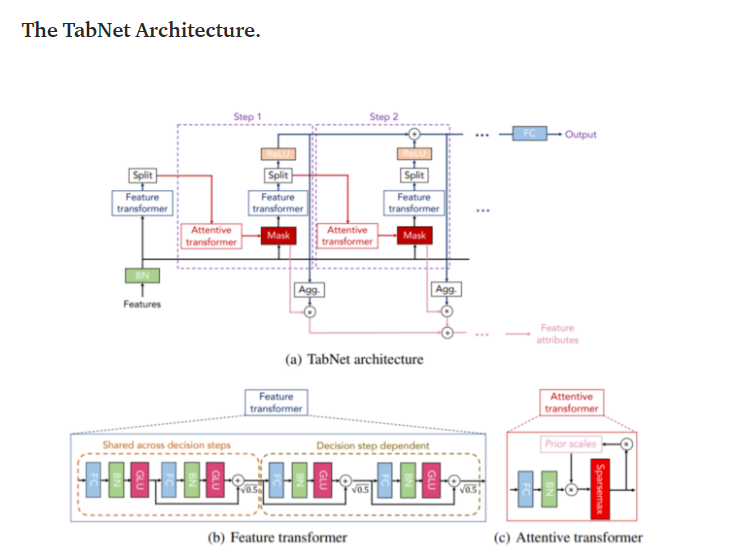

Andiamo a definire singolarmente i vari componenti per poi assemblarli.

In [ ]:
""" Ghost Batch Normalization (GBN):
 Questa tenica ci consente di operare su grandi batch di dati e al tempo stesso ottenere buone generalizzazioni.
 In pratica: viene diviso il batch di in input in sotto-batch di dimensioni uguali (dimensione del batch 
 virtuale) e viene applicato lo stesso livello di Batch Normalization. 
 Tutti i layer di normalizzazione del modello, eccetto il primo, adottano questa tecnica. """

class GBN(nn.Module):
  def __init__(self,inp,vbs=128,momentum=0.01):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs
        
  def forward(self,x):
        chunk = torch.chunk(x,x.size(0)//self.vbs,0)
        res = [self.bn(y) for y in chunk]
        return torch.cat(res,0)

""" SparseMax: 
  essa è una funzione di normalizzazione lineare come Softmax ma con una distribuzione più sparsa.
  Ovvero rispetto a Softmax alcuni numeri nella distribuzione della probabilità di output sono molto vicini
  a 1 mentre altri molto più vicini a 0; ciò consente al modello di selezionare le caratteristiche rilevanti in 
  ogni fase deciionale in modo più efficace. 
  Useremo Sparsemax per progettare la maschera per il passaggio di selezione delle features su uno spazio più ristretto. """

!pip install -U sparsemax

from sparsemax import Sparsemax

""" Attention Transformer: 
  è la fase in cui modelli apprendono la relazione tra le caratteristiche rilevanti e decidono quali trasferire al Feature Transformer.
  Ciascun Attention Transformer è costituito da: 
    - un livello completamente connesso;
    - un livello di GBN;
    - un livello Sparsemax.
  L'attention transformer in ogni fase decisionale riceve le caratteristiche di input, quelle elaborate nella fase precedente e le informazioni preliminari
  sulle caratteristiche utilizzate. 
  Tutte queste info sono rappresentate da una matrice di dim batch_size x input_features. Essa viene aggiornata in ogni fase decisionale.
  Esiste anche un parametro di "rilassamento" che limita il numero di volte in cui una determinata funzione può essere utilizzata in un passaggio in avanti. """

class AttentionTransformer(nn.Module):

    def __init__(self,d_a,inp_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(d_a,inp_dim)
        #self.bn = GBN(out_dim,vbs=vbs)
        self.bn = GBN(inp_dim, vbs=vbs)
        self.smax = Sparsemax()
        self.r = relax
    
    #a:feature from previous decision step
    
    def forward(self,a,priors): 
        a = self.bn(self.fc(a)) 
        mask = self.smax(a*priors) 
        priors =priors*(self.r-mask)  #updating the prior
        return mask

""" Feautre Transformer: 
 Il trasformatore di caratteristiche è dove tutte le caratteristiche selezionate vengono elaborate per generare l'output finale. 
 
 Ogni trasformatore di caratteristiche è composto da più Gated Linear Unit Blocks.
 Una GLU controlla quali informazioni devono essere autorizzate a fluire ulteriormente attraverso la rete. 
 Per implementare un blocco GLU, prima raddoppiamo la dimensione delle caratteristiche di input alla GLU utilizzando uno strato completamente connesso.
 Normalizziamo la matrice risultante utilizzando un GBN Layer. Quindi, applichiamo un sigmoide alla seconda metà delle caratteristiche risultanti 
 e moltiplichiamo i risultati per la prima metà. Il risultato viene moltiplicato per un fattore di scala (sqrt (0,5) in questo caso) e aggiunto all'input. 
 Questo risultato sommato è l'input per il blocco GLU successivo nella sequenza.

 Un certo numero di blocchi GLU è condiviso tra tutte le fasi decisionali per promuovere la capacità e l'efficienza del modello (opzionale). 
 Il primo blocco GLU condiviso (o il primo blocco indipendente se non ci sono blocchi condivisi) è unico in quanto riduce la dimensione 
 delle features di input ad una dimensione uguale n_a + n_d. 
 n_a è la dimensione delle caratteristiche in ingresso al trasformatore di attenzione del passaggio successivo e 
 n_d è la dimensione delle caratteristiche utilizzate per calcolare i risultati finali. 
 Queste caratteristiche vengono elaborate insieme fino a raggiungere lo splitter. 
 L'attivazione di ReLU viene applicata al vettore dimensionato n_d. 
 Gli output di tutte le fasi decisionali vengono sommati e passati attraverso un livello completamente connesso per mapparli alla dimensione di output. """

class GLU(nn.Module):

  def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
      super().__init__()
      if fc:
          self.fc = fc
      else:
          self.fc = nn.Linear(inp_dim,out_dim*2)
      self.bn = GBN(out_dim*2,vbs=vbs) 
      self.od = out_dim

  def forward(self,x):
      x = self.bn(self.fc(x))
      return x[:,:self.od]*torch.sigmoid(x[:,self.od:])

class FeatureTransformer(nn.Module):

  def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
      super().__init__()
      first = True
      self.shared = nn.ModuleList()
      if shared:
          self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
          first= False    
          for fc in shared[1:]:
              self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
      else:
          self.shared = None
      self.independ = nn.ModuleList()
      if first:
          self.independ.append(GLU(inp,out_dim,vbs=vbs))
      for x in range(first, n_ind):
          self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
      self.scale = torch.sqrt(torch.tensor([.5],device=device))

  def forward(self,x):
      if self.shared:
          x = self.shared[0](x)
          for glu in self.shared[1:]:
              x = torch.add(x, glu(x))
              x = x*self.scale
      for glu in self.independ:
          x = torch.add(x, glu(x))
          x = x*self.scale
      return x
      
""" Combiniamo Attention Transformer e Feature Transformer in un DecisionStep """

class DecisionStep(nn.Module):
  
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran =  AttentionTransformer(n_a,inp_dim,relax,vbs)
    
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        sparse_loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,sparse_loss

In [ ]:
""" Creiamo ora il modello completo mediante gli elementi definiti """

class TabNet(nn.Module):
    def __init__(self,inp_dim, final_out_dim, n_d=64, n_a=64, n_shared=3, n_ind=2, n_steps=5, relax=1.2, vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim)
        self.n_d = n_d

    def forward(self,x):
        x = self.bn(x)
        x_a = self.first_step(x)[:,self.n_d:]
        sparse_loss = torch.zeros(1).to(x.device)
        out = torch.zeros(x.size(0),self.n_d).to(x.device)
        priors = torch.ones(x.shape).to(x.device)
        for step in self.steps:
            x_te,l = step(x,x_a,priors)
            out += F.relu(x_te[:,:self.n_d])
            x_a = x_te[:,self.n_d:]
            sparse_loss += l
        return self.fc(out),sparse_loss

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output, _ = model(x)
        loss = F.cross_entropy(output, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out,_ = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    #print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("ep ", i, " training loss: ", loss)
        val_loss(model, valid_dl)

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class AndMal_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = AndMal_Dataset(train, y_train)
valid_ds = AndMal_Dataset(validation, y_val)

In [ ]:
print('Lunghezza train: ', len(train))
print('Lunghezza validation: ', len(validation))
print('Lunghezza test: ', len(test))

Lunghezza train:  47760
Lunghezza validation:  2500
Lunghezza test:  50261


In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """

# Per TabNet ogni singolo batch deve essere di lunghezza >= a 128 (che sarebbe il vbs)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
model = TabNet(inp_dim=len(cont_names), final_out_dim=5)
to_device(model, device)

TabNet(
  (shared): ModuleList(
    (0): Linear(in_features=66, out_features=256, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (first_step): FeatureTransformer(
    (shared): ModuleList(
      (0): GLU(
        (fc): Linear(in_features=66, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (1): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (2): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (independ): ModuleList(
      (0): GLU(
        (fc): 

In [ ]:
train_loop(model, epochs=500, lr=0.001, wd=0.000001)

ep  0  training loss:  0.7254245714725961
valid loss  0.7450845735549927  and accuracy  0.8736
ep  1  training loss:  0.5795362719938384
valid loss  0.5760305516242981  and accuracy  0.8704
ep  2  training loss:  0.5693202984592624
valid loss  0.5604301150321961  and accuracy  0.8728
ep  3  training loss:  0.5675133659611994
valid loss  0.556142356967926  and accuracy  0.8728
ep  4  training loss:  0.5621861119366172
valid loss  0.5507300025939942  and accuracy  0.8712
ep  5  training loss:  0.5592302564400524
valid loss  0.5452161146163941  and accuracy  0.8732
ep  6  training loss:  0.5577016460635954
valid loss  0.5458666650772095  and accuracy  0.8736
ep  7  training loss:  0.5574221412540481
valid loss  0.5437821208000183  and accuracy  0.8736
ep  8  training loss:  0.5582312256047873
valid loss  0.5457792246818542  and accuracy  0.8736
ep  9  training loss:  0.5561187221975982
valid loss  0.5366519411563874  and accuracy  0.8736
ep  10  training loss:  0.5545606930451576
valid lo

# ***EVALUATION***

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """


' Effettuiamo le predizioni sul dataset di test '

In [ ]:
## Cella per salvare il modello
#path = F'./drive/MyDrive/Models/AndMal_TabNet_PyTorch.pt'
#torch.save(model.state_dict(), path)


In [ ]:
# codice per caricarlo 
#path = F'./drive/MyDrive/Models/NLSKDD_TabNet_PyTorch.pt'
#model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# per batch_size = 512 l'ultimo batch risulta di 87 elementi che è < di 128

batch_size = 511

test_ds = AndMal_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

#test_tensor = torch.from_numpy(test_dl.dl.dataset.X)

In [ ]:
preds = []
with torch.no_grad():
  model.eval()
  for x, y in test_dl:
    out, l = model(x)
    prob = F.softmax(out, dim=1)
    preds.append(prob)

In [ ]:
preds

In [ ]:
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([4, 4, 4, ..., 4, 4, 4])

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({4: 43646, 1: 2210, 0: 1812, 2: 1468, 3: 1125})
Pred: Counter({4: 49021, 1: 530, 2: 321, 0: 308, 3: 81})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

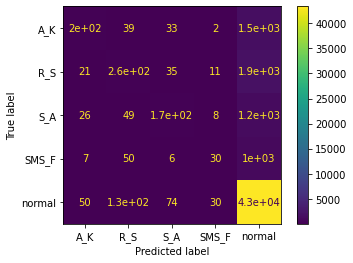

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# dizionario
target_dict = {'A_K' : 0,
               'R_S' : 1,
               'S_A' : 2,
               'SMS_F' : 3,
               'normal' : 4
               }

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[48345   104]
  [ 1608   204]]

 [[47783   268]
  [ 1948   262]]

 [[48645   148]
  [ 1295   173]]

 [[49085    51]
  [ 1095    30]]

 [[  956  5659]
  [  284 43362]]]


In [ ]:
print(cm)

[[  204    39    33     2  1534]
 [   21   262    35    11  1881]
 [   26    49   173     8  1212]
 [    7    50     6    30  1032]
 [   50   130    74    30 43362]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.66      0.11      0.19      1812
           1       0.49      0.12      0.19      2210
           2       0.54      0.12      0.19      1468
           3       0.37      0.03      0.05      1125
           4       0.88      0.99      0.94     43646

    accuracy                           0.88     50261
   macro avg       0.59      0.27      0.31     50261
weighted avg       0.84      0.88      0.83     50261



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.8760470344800143
Precision_weighted:  0.8377861545518283
Recall_weighted:  0.8760470344800143
mcc:  0.26034152920913534
f2:  0.8681178150001322
